In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder,RobustScaler

In [ ]:
df = pd.read_csv('/content/Churn_Modelling.csv')

In [ ]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
df.drop(columns = ['RowNumber','CustomerId','Surname'],inplace=True)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


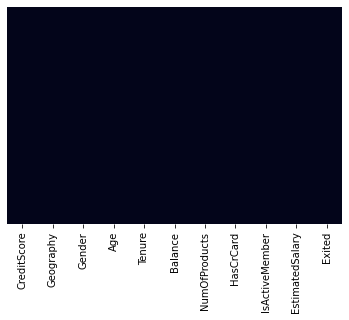

In [ ]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False)


In [ ]:
df.drop_duplicates(inplace=True)


In [ ]:
df.shape

(10000, 11)

In [ ]:

categorical_cols = []
categorical_inds = []
counting_cols = []
counting_inds  = []
cnt=0
for i in df.drop(['Exited'],axis=1).columns:
    cnt+=1
    if df[i].nunique()<=5:
        categorical_cols.append(i)
        categorical_inds.append(cnt-1)
    

      
    else:
        counting_cols.append(i)
        counting_inds.append(cnt-1)

In [ ]:
categorical_cols


['Geography', 'Gender', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test =train_test_split(df.drop(['Exited'],axis=1),
                                                df['Exited'],
                                                test_size=0.3,
                                                random_state=101,stratify=df['Exited'])

X_train = X_train.values
y_train = y_train.values
X_test  = X_test.values
y_test  = y_test.values

In [ ]:
#Numerical
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])


#Categorical
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe',OneHotEncoder(handle_unknown='ignore',drop='first')),
])



preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, counting_inds),
        ('cat', categorical_transformer, categorical_inds)
    ],remainder='passthrough'
)

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, counting_inds),
        ('cat', categorical_transformer, categorical_inds)
    ],remainder='passthrough'
)

In [ ]:
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

In [ ]:
from sklearn import set_config
set_config(display='diagram')
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  [0, 3, 4, 5, 9]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  [1, 2, 6, 7, 8])]))])

In [ ]:
X_train = pipe.fit_transform(X_train)
X_test = pipe.transform(X_test)


In [ ]:
import  tensorflow
from tensorflow import keras
from keras.layers import Dense,Dropout,BatchNormalization
from keras import Sequential

In [ ]:
X_train.shape

(7000, 13)

In [ ]:

model = Sequential()
model.add(Dense(8,activation='elu',input_dim=13))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(16,activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(32,activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(32,activation='elu'))
model.add(Dense(1,activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_100 (Dense)           (None, 8)                 112       
                                                                 
 batch_normalization_40 (Bat  (None, 8)                32        
 chNormalization)                                                
                                                                 
 dropout_40 (Dropout)        (None, 8)                 0         
                                                                 
 dense_101 (Dense)           (None, 16)                144       
                                                                 
 batch_normalization_41 (Bat  (None, 16)               64        
 chNormalization)                                                
                                                                 
 dropout_41 (Dropout)        (None, 16)              

In [ ]:
model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
X_train = np.asarray(X_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)

In [ ]:
history = model.fit(X_train,y_train,epochs=25,verbose=1,validation_split=0.2)

In [ ]:
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=-1)

94/94 [==============================] - 0s 2ms/step


In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.7926666666666666

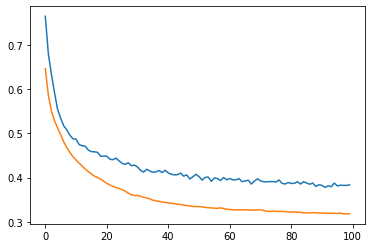

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

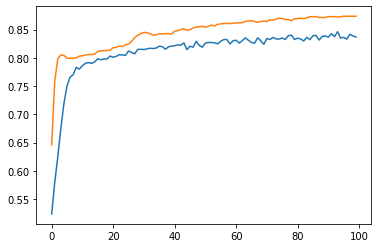

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
